In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
allocs = pd.Series([.05, .3, .35, .3, 1], index=['CL', 'ES', 'GC', 'NQ', 'total'])
cash = 100000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-03-01_19-55_20190101_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df

,contract,action,amount,price,order_id,reason,commission,realizedPNL,comm_reports,cash
time,,,,,,,,,,
2019-01-02 01:56:00,NQ,BUY,3,6381.600,1,ENTRY,6.30,0.00,"[CommissionReport(execId=1, commission=6.30000...",100000.00
2019-01-02 02:10:00,ES,BUY,3,2519.050,3,ENTRY,6.30,0.00,"[CommissionReport(execId=2, commission=6.30000...",100000.00
2019-01-02 02:59:00,NQ,SELL,3,6345.700,2,STOP-LOSS,6.30,-2166.60,"[CommissionReport(execId=3, commission=6.30000...",97833.40
2019-01-02 05:04:00,ES,SELL,3,2483.125,4,STOP-LOSS,6.30,-5401.35,"[CommissionReport(execId=4, commission=6.30000...",92432.05
2019-01-02 06:19:00,GC,BUY,4,1287.200,5,ENTRY,9.68,0.00,"[CommissionReport(execId=5, commission=9.68, c...",92432.05
...,...,...,...,...,...,...,...,...,...,...
2019-12-30 15:49:00,NQ,SELL,2,8712.550,1972,ENTRY,4.20,0.00,"[CommissionReport(execId=1729, commission=4.2,...",163773.62
2019-12-30 15:54:00,NQ,BUY,2,8721.300,1973,STOP-LOSS,4.20,-358.40,"[CommissionReport(execId=1730, commission=4.2,...",163415.22
2019-12-30 16:06:00,NQ,SELL,2,8718.600,1974,ENTRY,4.20,0.00,"[CommissionReport(execId=1731, commission=4.2,...",163415.22


In [4]:
df[(df['contract'] == 'NQ') & (df['realizedPNL'] == 0)].count()

contract        236
action          236
amount          236
price           236
order_id        236
reason          236
commission      236
realizedPNL     236
comm_reports    236
cash            236
dtype: int64

In [5]:
df.groupby('contract').realizedPNL.sum()

contract
CL     2234.77
ES    30372.98
GC     1655.42
NQ    28967.91
Name: realizedPNL, dtype: float64

In [6]:
df.realizedPNL.sum()

63231.08000000001

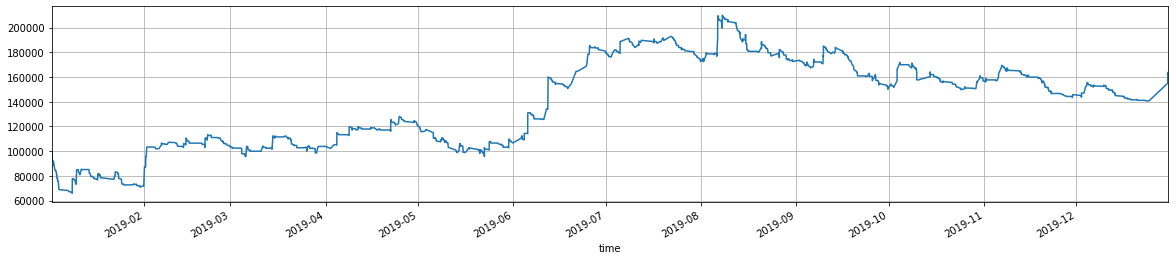

In [7]:
df.cash.plot(figsize=(20,4), grid=True);

In [8]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [9]:
# number of trades
trades = df.groupby('contract').action.count()
trades

contract
CL    516
ES    176
GC    569
NQ    472
Name: action, dtype: int64

In [10]:
# commission paid
df.groupby('contract').commission.sum()

contract
CL    1222.92
ES    1041.60
GC    4484.26
NQ    2343.60
Name: commission, dtype: float64

In [11]:
df.commission.sum()

9092.380000000001

In [12]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
NQ,0.22,122.75,4219.02,-1006.50,4.19,143.11,236.0
ES,0.43,345.15,3682.00,-2190.86,1.68,334.47,88.0
CL,0.20,8.66,1217.65,-289.21,4.21,12.16,258.0
GC,0.19,5.83,3416.46,-813.32,4.20,-9.66,284.0
total,0.23,73.02,3103.03,-807.54,3.84,91.89,866.0


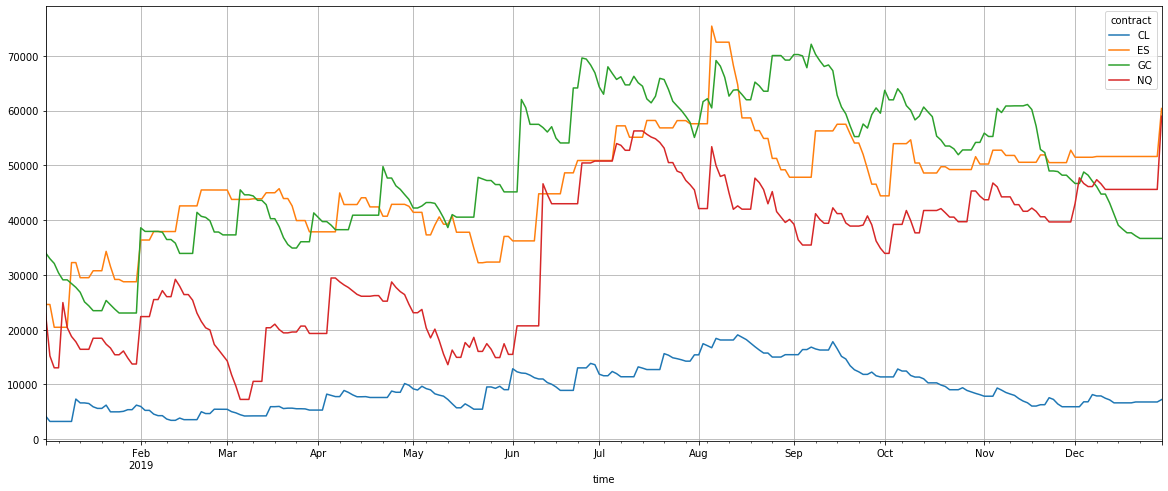

In [13]:
daily = by_contract.resample('B').sum()
daily = daily.cumsum() +  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [15]:
# instrument correlations
log_returns = np.log(daily.pct_change()[1:] + 1)
log_returns.corr()

contract,CL,ES,GC,NQ,total
contract,,,,,
CL,1.000000,0.054905,-0.007027,0.035190,0.188304
ES,0.054905,1.000000,0.093340,0.236870,0.615367
GC,-0.007027,0.093340,1.000000,0.098173,0.599309
NQ,0.035190,0.236870,0.098173,1.000000,0.696280
total,0.188304,0.615367,0.599309,0.696280,1.000000


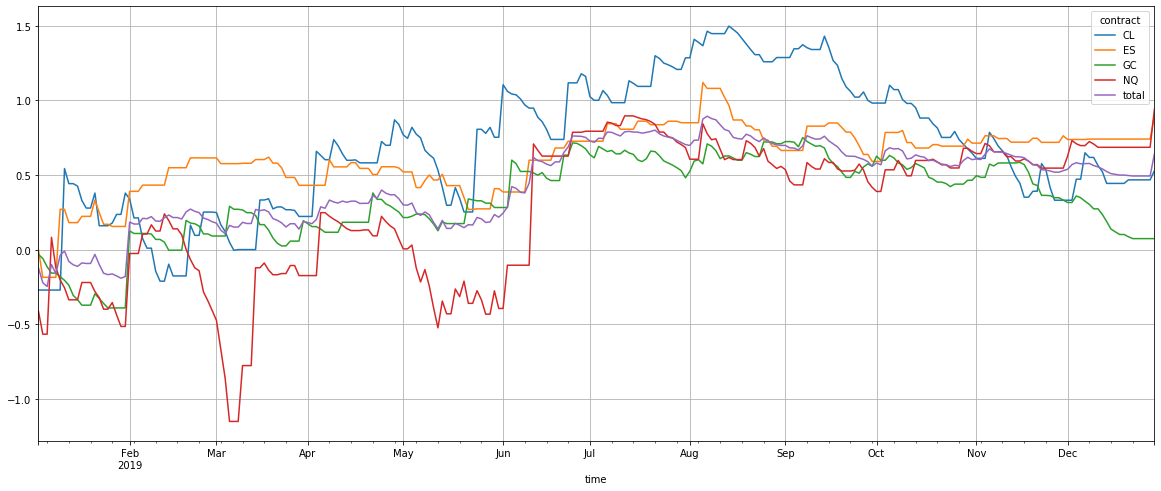

In [16]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

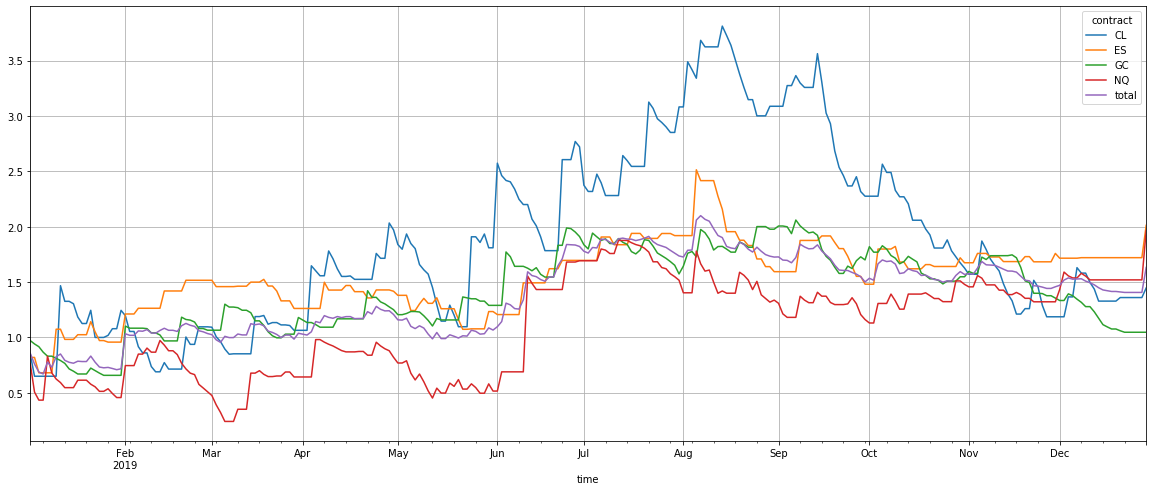

In [17]:
returns = daily.pct_change()
returns.iloc[0] = (daily.iloc[0] / (allocs * cash))-1
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [18]:
stats = pd.DataFrame()
for col in returns.columns:
    stats[col] = perf_stats(returns[col])
stats

,CL,ES,GC,NQ,total
Annual return,0.432577,0.974753,0.045990,0.930022,0.610836
Cumulative returns,0.446954,1.012433,0.047298,0.965597,0.632311
Annual volatility,1.993506,0.974387,1.008673,2.302842,0.737468
Sharpe ratio,0.906622,1.119676,0.453891,1.116175,0.978625
Calmar ratio,0.628240,2.372333,0.093544,1.227411,1.850820
Stability,0.246448,0.490300,0.378012,0.567407,0.580323
Max drawdown,-0.688554,-0.410884,-0.491644,-0.757710,-0.330035
Omega ratio,1.314127,1.472178,1.142290,1.430135,1.261039
Sortino ratio,2.695749,2.647171,1.388541,3.205668,2.193902
Skew,5.474923,4.383819,6.130638,4.918579,3.980259


In [19]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

contract,CL,ES,GC,NQ,total
time,,,,,
2019-01-31,46.11,16.86,-32.29,-40.20,-16.43
2019-02-28,-11.95,58.25,61.88,11.36,44.35
2019-03-31,-2.88,-16.77,10.77,26.25,0.24
2019-04-30,85.10,12.31,5.96,27.60,16.36
2019-05-31,-8.17,-12.93,3.13,-37.12,-11.66
2019-06-30,50.35,37.42,48.15,227.81,70.69
2019-07-31,13.24,13.19,-17.65,-10.38,-4.70
2019-08-31,0.19,-16.96,25.64,-11.83,-0.57
2019-09-30,-26.30,-7.10,-14.01,-13.11,-12.99


In [20]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
CL        70.0
ES       145.0
GC         8.0
NQ       157.0
total     90.0
dtype: float64

In [21]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-06-12 07:30:00,NQ,SELL,7521.386298,25933.58
2019-08-06 10:36:00,ES,BUY,2851.900000,17826.15
2019-06-05 16:55:00,GC,SELL,1336.180000,16868.64
2019-02-01 03:27:00,GC,SELL,1323.060000,15552.64
2019-08-06 09:42:00,NQ,BUY,7443.075000,14784.60
...,...,...,...,...
2019-05-06 00:01:00,ES,SELL,2903.525000,-4115.10
2019-01-04 07:26:00,ES,BUY,2468.075000,-4160.10
2019-08-13 15:45:00,ES,BUY,2900.550000,-4223.85
